# Simple use case for CML data from the OpenMRG dataset

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr
import pycomlink as pycml
import tqdm

## Load a small piece of data from the OpenMRG dataset
Please refer to [Explore existing open datasets](./Explore_existing_datasets.ipynb) on how to dowload and explore the whole datset.

In [2]:
cmls = xr.open_dataset('data/openMRG_example.nc')

The dataset consists of transmitted (tsl) and recieved (rsl) signal levels for one day with one minute resolution. The meta data includes length, frequency and location of all both nodes of each CML.

## Simple processing using pycomlink
The steps are briefily explained in the next cell, for detailed explanation see [Basic example of using pycomlink](./pycomlink_basic_example.ipynb)


In [3]:
# calculate total loss
cmls["tl"] = cmls.tsl - cmls.rsl
# seperate periods of rain from dry time steps
cmls["wet"] = cmls.tl.rolling(time=60, center=True).std(skipna=False) > 0.8
# estiamte the baseline during rain events
cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=cmls.tl,
    wet=cmls.wet,
    n_average_last_dry=5,
)
# compenmsate for wet antenna attenuation
cmls["waa"] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cmls.tl,
    baseline=cmls.baseline,
    wet=cmls.wet,
    waa_max=2.2,
    delta_t=1,
    tau=15,
)
# calculate attenuation caused by rain and remove negative attenuation
cmls["A"] = cmls.tl - cmls.baseline - cmls.waa
cmls["A"].values[cmls.A < 0] = 0
# derive rain rate via the k-R relation
cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=cmls.A,
    L_km=cmls.length.astype(float)/1000, # convert to km
    f_GHz=cmls.frequency/1000, # convert to GHz
    pol=cmls.polarization,
)

#### Compare attenuation time series to derived rain rate for one CML

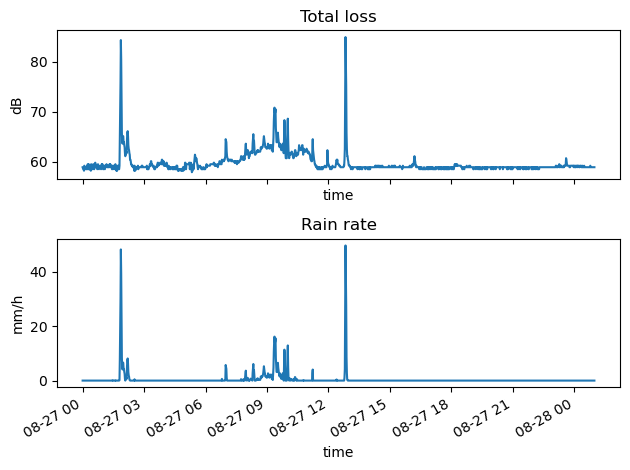

In [4]:
fig,ax = plt.subplots(2,1,sharex=True)
cmls.tl.isel(cml_id=90,sublink_id=0).plot(ax=ax[0])
ax[0].set_ylabel('dB')
ax[0].set_title('Total loss')
cmls.R.isel(cml_id=90,sublink_id=0).plot(ax=ax[1])
ax[1].set_ylabel('mm/h')
ax[1].set_title('Rain rate')
plt.tight_layout()

#### Remove some very short CMLs (< 1 km) with frequency below 30 GHz
Short CMLs sometimes show unreasonable high rainfall values. This behavior might stem from an underestimation of WAA but is not entirely clear

In [5]:
cmls_sel = cmls.where(~((cmls.length/1000 < 2) & (cmls.frequency/1000 < 30)),drop=True)
cmls_sel = cmls_sel.where(cmls.length/1000 > 1,drop=True).isel(sublink_id=0)

## Interpolate hourly CML rainfall estimates
Aggregate the rainfall values and interpolate hourly rainfall maps using Inverse distance weighting (IDW). 

In [6]:
# resampling to one hour
cmls_R_1h = cmls_sel.R.resample(time='1h', label='right').mean().to_dataset()

# extracting center point of each CML which is used in IDW
cmls_R_1h['lat_center'] = (cmls_R_1h.site_0_lat + cmls_R_1h.site_1_lat)/2
cmls_R_1h['lon_center'] = (cmls_R_1h.site_0_lon + cmls_R_1h.site_1_lon)/2

# define IDW parameters
idw_interpolator = pycml.spatial.interpolator.IdwKdtreeInterpolator(
    nnear=15, 
    p=2, 
    exclude_nan=True, 
    max_distance=0.3,
)
# do the interpolation for every hour of the sample day
R_grid_list=[]
for t in tqdm.tqdm(cmls_R_1h.time):
    R_grid_list.append(idw_interpolator(
        x=cmls_R_1h.lon_center, 
        y=cmls_R_1h.lat_center, 
        z=cmls_R_1h.R.sel(time=t), 
        resolution=0.01,
    ))
# sum up hourly maps to one day
cml_rain_sum=np.array(R_grid_list).sum(axis=0)

100%|██████████████████████████████████████████| 25/25 [00:45<00:00,  1.81s/it]


#### Plot the daily rainfall sum and the CML paths

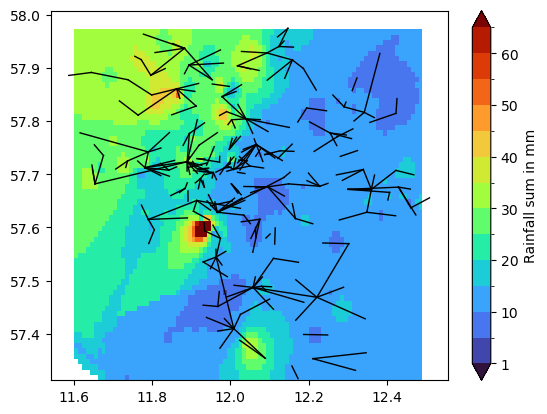

In [7]:
def plot_cml_lines(ds_cmls, ax):
    ax.plot(
        [ds_cmls.site_0_lon, ds_cmls.site_1_lon],
        [ds_cmls.site_0_lat, ds_cmls.site_1_lat],
        'k',
        linewidth=1,
    )
bounds = np.arange(0, 70, 5.0)
bounds[0] = 1
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
   
fig,ax=plt.subplots()
pc = plt.pcolormesh(
    idw_interpolator.xgrid, 
    idw_interpolator.ygrid, 
    cml_rain_sum, 
    shading='nearest', 
    cmap='turbo',
    norm=norm,
)
plot_cml_lines(cmls_R_1h, ax=ax)
fig.colorbar(pc, label='Rainfall sum in mm');

#### Hourly rainfall maps 

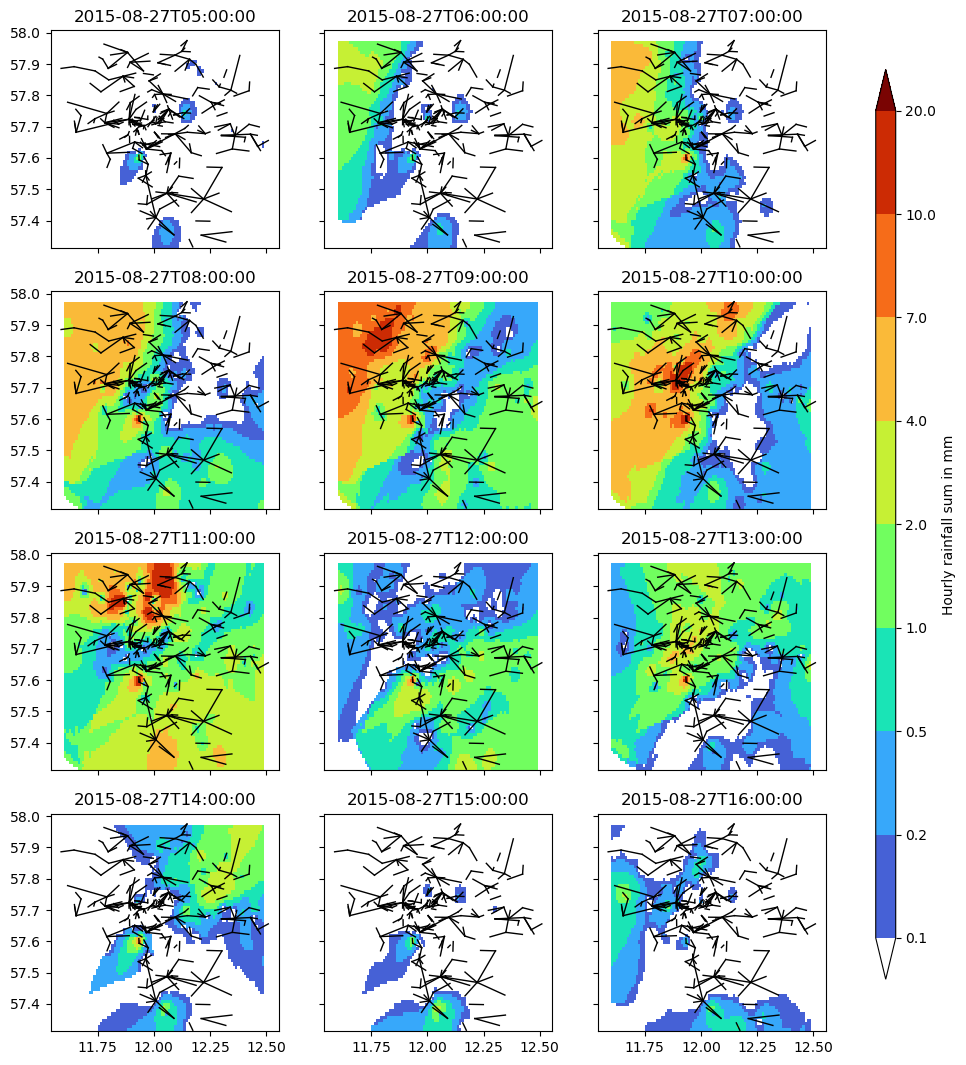

In [8]:
fig, ax = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(10, 13))

bounds = [0.1, 0.2, 0.5, 1, 2, 4, 7, 10, 20] 
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
cmap = plt.get_cmap('turbo').copy()
cmap.set_under('w')

for i, axi in enumerate(ax.flat):
    pc = axi.pcolormesh(
        idw_interpolator.xgrid, 
        idw_interpolator.ygrid, 
        R_grid_list[i+4], 
        shading='nearest', 
        cmap=cmap,
        norm=norm,
    )
    axi.set_title(str(cmls_R_1h.time.values[i + 4])[:19])
    
    plot_cml_lines(cmls_R_1h, ax=axi)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb = fig.colorbar(pc, cax=cbar_ax, label='Hourly rainfall sum in mm', );

#### Animation of 24 hours of rainfall
Uses the hourly interpolated maps generated above and creates an animation. 

In [9]:
import matplotlib.animation as animation

fig = plt.figure()

extent=[
    idw_interpolator.xgrid.min(),
    idw_interpolator.xgrid.max(),
    idw_interpolator.ygrid.min(),
    idw_interpolator.ygrid.max()]

ax = plt.axes()
im = ax.imshow(R_grid_list[0], cmap=cmap, norm=norm, origin="lower", extent=extent)
plt.plot(
    [cmls_sel.site_0_lon, cmls_sel.site_1_lon],
    [cmls_sel.site_0_lat, cmls_sel.site_1_lat],
    "k",
    linewidth=1,
)
im.set_data(np.zeros(R_grid_list[0].shape))
cbar = fig.colorbar(im)
title = ax.text(
    0.5,
    01.05,
    "",
    bbox={"facecolor": "w", "alpha": 0.5, "pad": 5},
    transform=ax.transAxes,
    ha="center",
)


def update_data(n):
    grid = R_grid_list[n]  # More random data
    im.set_data(grid)
    title.set_text("{}".format(str(cmls_R_1h.isel(time=n).time.values)[:19]))
    return title





ani = animation.FuncAnimation(fig, update_data, frames=len(R_grid_list))
plt.close()
from IPython.display import HTML
HTML(ani.to_jshtml())

# Extended use case with comparison to radar
The following code uses the CML rainfall estimation that we calculated above and plots it together with weather radar images for the same timsteps. It is not important for understanding CML processing, but the visualization could provide a clearer view on what is going on.

### Prepare CML data for 5 min resolution and load radar data
In order to make the animation we aggregate the CML data to 5 minutes so that it is the same as the radar resolution. 

In [10]:
# Define the time interval to use
time_start_5T = '2015-08-27T01:00' # this also the available time in the prepared radar netcdf
time_end_5T = '2015-08-27T02:30'
# Aggregate the CML data to 5 minutes mean to make it comparable to the radar data
cmls_R_5T = cmls_sel.R.sel(time = slice(time_start_5T, time_end_5T)).resample(
    time = '5T', label='right').mean().to_dataset()
# Add CML signal loss
cmls_R_5T['tl'] = cmls_sel.tl.sel(time = slice(time_start_5T, time_end_5T)).resample(
    time = '5T').first()
# Extracting center point of each CML which is used in IDW
cmls_R_5T['lat_center'] = (cmls_R_5T.site_0_lat + cmls_R_5T.site_1_lat)/2
cmls_R_5T['lon_center'] = (cmls_R_5T.site_0_lon + cmls_R_5T.site_1_lon)/2
# Load prepared radar data
ds_rad_5T = xr.open_dataset('./data/openMRG_example_rad.nc')

### Transform the CML and radar coordinates to UTM32 
Transforming the CML coordinates to UTM32 makes the distances along the x and y-axis comparable. We could also use the projection provided in the radar dataset. 

In [11]:
# Import libraries used for transforming to UTM coordinates 
from pyproj import CRS
from pyproj import Transformer

In [12]:
# Transform to UTM coordinate system
# define projection: https://epsg.io/32632
crs = CRS('EPSG:32632') # Norway: EPSG:32632, Sweden: 32633, 
# gotenburg is between these two

# set source coordinates
crs_source = CRS('EPSG:4326') # latitude longitude wgs84

# Create Transformer to convert from geodetic CRS to CRS: https://pyproj4.github.io/pyproj/stable/examples.html
proj = Transformer.from_crs(crs_source, crs, always_xy=True)

# do transform for CML and radar
site_0_x, site_0_y = proj.transform(cmls_R_5T.site_0_lon.values, cmls_R_5T.site_0_lat.values)
cmls_R_5T['site_0_x'] = ('cml_id', site_0_x)
cmls_R_5T['site_0_y'] = ('cml_id', site_0_y)
site_1_x, site_1_y = proj.transform(cmls_R_5T.site_1_lon.values, cmls_R_5T.site_1_lat.values)
cmls_R_5T['site_1_x'] = ('cml_id', site_1_x)
cmls_R_5T['site_1_y'] = ('cml_id', site_1_y)
x_center, y_center = proj.transform(cmls_R_5T.lon_center.values, cmls_R_5T.lat_center.values)
cmls_R_5T['x_center'] = ('cml_id', x_center)
cmls_R_5T['y_center'] = ('cml_id', y_center)
x_proj, y_proj= proj.transform(ds_rad_5T.lon.values, ds_rad_5T.lat.values)
ds_rad_5T['x_proj'] = (('y', 'x'), x_proj)
ds_rad_5T['y_proj'] =( ('y', 'x'), y_proj)

# scale the data from meter to km
scale = 1000
ds_rad_5T['x_proj'] = ds_rad_5T['x_proj']/scale
ds_rad_5T['y_proj'] = ds_rad_5T['y_proj']/scale
cmls_R_5T['site_0_x'] = cmls_R_5T['site_0_x']/scale
cmls_R_5T['site_0_y'] = cmls_R_5T['site_0_y']/scale
cmls_R_5T['site_1_x'] = cmls_R_5T['site_1_x']/scale
cmls_R_5T['site_1_y'] = cmls_R_5T['site_1_y']/scale
cmls_R_5T['x_center'] = cmls_R_5T['x_center']/scale
cmls_R_5T['y_center'] = cmls_R_5T['y_center']/scale

#### Perform IDW interpolation

In [13]:
# define IDW parameters
idw_interpolator = pycml.spatial.interpolator.IdwKdtreeInterpolator(
    nnear=15, 
    p=2, 
    exclude_nan=True, 
    max_distance=10, # 10km max distance
)
# do the interpolation for every 5min
R_grid_list=[]
for t in tqdm.tqdm(cmls_R_5T.time):
    R_grid_list.append(idw_interpolator(
        x=cmls_R_5T.x_center, 
        y=cmls_R_5T.y_center, 
        z=cmls_R_5T.R.sel(time=t), 
        resolution=1, # each scaled 1 utm coordinate is 1km meter, this generates km grid
    ))
    

100%|██████████████████████████████████████████| 19/19 [00:38<00:00,  2.04s/it]


#### Make animation with radar and CMLs
The following cell plots what we have already calculated. It is only needed for visualisation and are not important to understand CML rainfall estimation.

In [14]:
from matplotlib.gridspec import GridSpec

In [15]:
import matplotlib.animation as animation
levels = np.linspace(0, 30, 8)
cmap = plt.get_cmap('turbo').copy()
cmap.set_under('w')
norm = mpl.colors.BoundaryNorm(levels, cmap.N, extend='both')
delta_time_front = pd.Timedelta('2H')
delta_time_back = pd.Timedelta('1H')

cml_i = 1 # CML id to plot timeseries for
cml_plot_name = cmls_R_5T.isel(cml_id = cml_i).cml_id.values
fig = plt.figure(figsize =(12, 4))
gs = GridSpec(1, 3)
ax = []
gs_cml = GridSpec(1, 2, left=0.07, right=0.55, wspace=0.1, top = 0.8)
ax.append(fig.add_subplot(gs_cml[0]))
ax.append(fig.add_subplot(gs_cml[1]))
gs2 = GridSpec(1, 1, left=0.67, right=0.87, top = 0.8)
ax.append(fig.add_subplot(gs2[0]))

extent=[
    idw_interpolator.xgrid.min(),
    idw_interpolator.xgrid.max(),
    idw_interpolator.ygrid.min(),
    idw_interpolator.ygrid.max()
]
x_grid_cml = np.linspace(
    idw_interpolator.xgrid.min(), 
    idw_interpolator.xgrid.max(), 
    R_grid_list[0].shape[1]
)
y_grid_cml = np.linspace(
    idw_interpolator.ygrid.min(), 
    idw_interpolator.ygrid.max(), 
    R_grid_list[0].shape[0]
)
x_grid_cml, y_grid_cml = np.meshgrid(
    x_grid_cml, 
    y_grid_cml
)
im_rad = ax[2].contourf(
    ds_rad_5T.x_proj, 
    ds_rad_5T.y_proj, 
    ds_rad_5T.rainfall[0].values,  
    levels = levels, 
    cmap=cmap,
    extend="max"
)
cbar_ax = fig.add_axes([0.56, 0.15, 0.02, 0.6]) # (left, bottom, width, height)
fig.colorbar(im_rad, cax=cbar_ax)

def update_data(n):
    ax[0].clear()
    ax[1].clear()
    ax[2].clear()
    
    # plot the radar image
    ax[0].contourf(
        ds_rad_5T.x_proj, 
        ds_rad_5T.y_proj, 
        ds_rad_5T.rainfall[n].values,  
        levels = levels, 
        cmap=cmap,
        extend="max"
    )
    # set radar boundaries to the same values as the CML map
    ax[0].set_xlim(idw_interpolator.xgrid.min(), idw_interpolator.xgrid.max())
    ax[0].set_ylim(idw_interpolator.ygrid.min(), idw_interpolator.ygrid.max())
    ax[0].set_xlabel('Possition x [km]')
    ax[0].set_title('Radar')
    ax[0].set_ylabel('Possition y [km]')
    # Remove y axis coords (already plotted by CML map)

    # plot the interpolated CML
    ax[1].contourf(
        x_grid_cml, 
        y_grid_cml, 
        R_grid_list[n],  
        levels = levels, 
        cmap=cmap,
        extend="max"    
    )
    ax[1].set_xlim(idw_interpolator.xgrid.min(), idw_interpolator.xgrid.max())
    ax[1].set_ylim(idw_interpolator.ygrid.min(), idw_interpolator.ygrid.max())
    # plot all CML lines
    ax[1].plot(
        [cmls_R_5T.site_0_x, cmls_R_5T.site_1_x],
        [cmls_R_5T.site_0_y, cmls_R_5T.site_1_y],
        "k",
        linewidth=1,
    )
    ax[1].tick_params(
        top=False, 
        bottom=False, 
        left=False, 
        right=False,
        labelleft=False, 
        labelbottom=False, 
        axis = 'y', 
        which='both'
    )    # plot visualized CML red
    ax[1].plot(
        [cmls_R_5T.isel(cml_id = cml_i).site_0_x, 
         cmls_R_5T.isel(cml_id = cml_i).site_1_x],
        [cmls_R_5T.isel(cml_id = cml_i).site_0_y, 
         cmls_R_5T.isel(cml_id = cml_i).site_1_y],
        "red",
        linewidth=5,
    )    
    ax[1].set_xlabel('Possition x [km]')
    ax[1].set_title('Interpolated CMLs')
    #cbar_cml.ax.set_ylabel('Rainfall [mm/h]', fontsize=10)

    
    # plot the CML signal for time interval
    times = cmls.time.sel(time = slice(
        cmls_R_5T.time[n].values - delta_time_back, 
        cmls_R_5T.time[n].values + delta_time_front)
                         )
    ax[2].plot(
        cmls.sel(time = times, cml_id = cml_plot_name).tl.isel(
            sublink_id = 0).values, 
        label = 'CML')
    
    # get time idx of red line and draw vertical red line
    time1 = np.timedelta64(delta_time_back, 'h').astype(int)
    time2 = np.timedelta64(delta_time_front, 'h').astype(int)
    poss = time1/(time1 + time2)
    ax[2].axvline(x = len(times)*poss, color = 'r', label = 'Time')
    ax[2].yaxis.tick_right()
    ax[2].set_ylim(45, 80)
    ax[2].set_xlabel('Timestep [5min]')
    ax[2].set_ylabel('Signal loss [dBm]')
    ax[2].yaxis.set_ticks_position('right')
    ax[2].yaxis.set_label_position('right')
    ax[2].legend()
    ax[2].set_title('CML')
    
    # Print current time inside box
    title = ax[1].text( # timestep
        0.5,
        1.15,
        "",
        bbox={"facecolor": "w", "alpha": 0.5, "pad": 5},
        transform=ax[1].transAxes,
        ha="center",
    )
    
    title.set_text("{}".format(
        str(cmls_R_5T.isel(time=n).time.values)[:19])
    )
    cbar_ax.set_ylabel('Rainfall [mm/h]', fontsize=10)
    return title

ani = animation.FuncAnimation(fig, update_data, frames=len(R_grid_list), blit=False)
plt.close()
from IPython.display import HTML
HTML(ani.to_jshtml())